# Final

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

## 原始数据集

In [2]:
data_prefix = './data'
data_dev = os.path.join(data_prefix, 'dev.csv')
data_level_meta = os.path.join(data_prefix, 'level_meta.csv')
data_level_seq = os.path.join(data_prefix, 'level_seq.csv')
data_test = os.path.join(data_prefix, 'test.csv')
data_train = os.path.join(data_prefix, 'train.csv')

In [3]:
raw_level_seq_df = pd.read_csv(data_level_seq, sep='\t')
raw_level_meta_df = pd.read_csv(data_level_meta, sep='\t')
raw_train_df = pd.read_csv(data_train, sep='\t')
raw_dev_df = pd.read_csv(data_dev, sep='\t')
raw_test_df = pd.read_csv(data_test)

训练集、验证机和测试集样本数量，`user_id`分布

In [4]:
len(raw_train_df), len(raw_dev_df), len(raw_test_df),

(8158, 2658, 2773)

In [5]:
sum([len(raw_train_df), len(raw_dev_df), len(raw_test_df)])

13589

* 共`13589`个用户
* 训练集`user_id`分布 `2774 ~ 10931`，有标签
* 验证集`user_id`分布 `10932 ~ 13589`，有标签
* 测试集`user_id`分布 `1 ~ 2773`，无标签

In [6]:
raw_level_seq_df.head(5).T

,0,1,2,3,4
user_id,10932,10932,10932,10932,10932
level_id,1,2,3,4,5
f_success,1,1,1,1,1
f_duration,127,69,67,58,83
f_reststep,0.5,0.703704,0.56,0.7,0.666667
f_help,0,0,0,0,0
time,2020-02-01 00:05:51,2020-02-01 00:08:01,2020-02-01 00:09:50,2020-02-01 00:11:16,2020-02-01 00:13:12


* `user_id`：用户 id，和训练、验证、测试集中的可以匹配
* `level_id`：关卡 id
* `f_success`：是否通关（1：通关，0：失败）
* `f_duration`：此次尝试所用的时间（单位 s）
* `f_reststep`：剩余步数与限定步数之比（失败为 0）
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）
* `time`：时间戳

In [7]:
raw_level_meta_df.head(5).T

,0,1,2,3,4
f_avg_duration,39.889940,60.683975,76.947355,58.170347,101.784577
f_avg_passrate,0.944467,0.991836,0.991232,0.993843,0.954170
f_avg_win_duration,35.582757,56.715706,71.789943,54.842882,85.650547
f_avg_retrytimes,0.017225,0.004638,0.004480,0.004761,0.027353
level_id,1.000000,2.000000,3.000000,4.000000,5.000000


In [8]:
raw_level_meta_df.tail(5).T

,1504,1505,1506,1507,1508
f_avg_duration,594.878788,486.56250,325.968750,793.096774,423.406250
f_avg_passrate,0.453730,0.45418,0.573525,0.322684,0.461409
f_avg_win_duration,133.625000,115.90625,86.250000,164.000000,106.833333
f_avg_retrytimes,3.187500,3.21875,2.687500,5.419355,2.200000
level_id,1505.000000,1506.00000,1507.000000,1508.000000,1509.000000


* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配

通关序列数据

In [9]:
raw_level_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


* `user_id` 用户ID
* `level_id` 关卡ID
* `f_success` 是否通关
* `f_duration` 此次尝试所用时间（单位：秒）
* `f_reststep` 剩余步数与限定步数之比（失败为0）
* `f_help` 是否使用道具
* `time` 时间戳

## 数据探索分析

level（关卡）数据特征

level概要信息

In [10]:
raw_level_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   f_avg_duration      1509 non-null   float64
 1   f_avg_passrate      1509 non-null   float64
 2   f_avg_win_duration  1509 non-null   float64
 3   f_avg_retrytimes    1509 non-null   float64
 4   level_id            1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.1 KB


* 共1509等级（关卡）
* 没有缺失数据

level数据分布

array([[<AxesSubplot:title={'center':'f_avg_duration'}>,
        <AxesSubplot:title={'center':'f_avg_passrate'}>],
       [<AxesSubplot:title={'center':'f_avg_win_duration'}>,
        <AxesSubplot:title={'center':'f_avg_retrytimes'}>]], dtype=object)

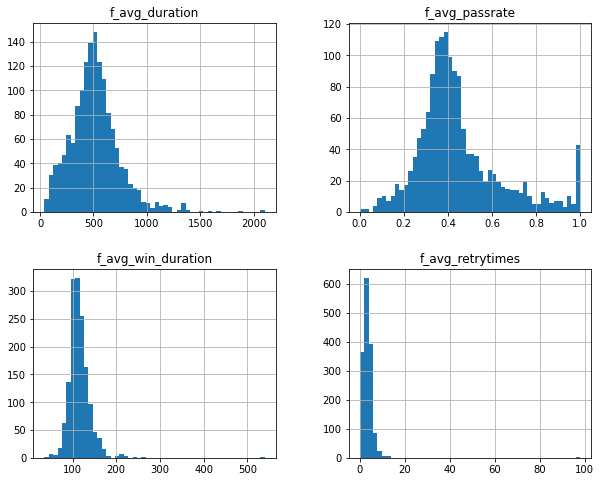

In [11]:
feats = ['f_avg_duration', 'f_avg_passrate', 'f_avg_win_duration', 'f_avg_retrytimes']
raw_level_meta_df[feats].hist(figsize=(10, 8), bins=50)

In [12]:
raw_level_meta_df[raw_level_meta_df.f_avg_retrytimes>20]

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
966,1003.0,0.021739,123.0,21.0,967
982,1128.0,0.000000,540.0,98.0,983
1014,1091.0,0.000000,540.0,98.0,1015


In [13]:
raw_level_meta_df[raw_level_meta_df.f_avg_win_duration>300]

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
982,1128.0,0.0,540.0,98.0,983
1014,1091.0,0.0,540.0,98.0,1015


`983`, `1015`数据可能是异常值

array([[<AxesSubplot:title={'center':'f_avg_duration'}>,
        <AxesSubplot:title={'center':'f_avg_passrate'}>],
       [<AxesSubplot:title={'center':'f_avg_win_duration'}>,
        <AxesSubplot:title={'center':'f_avg_retrytimes'}>]], dtype=object)

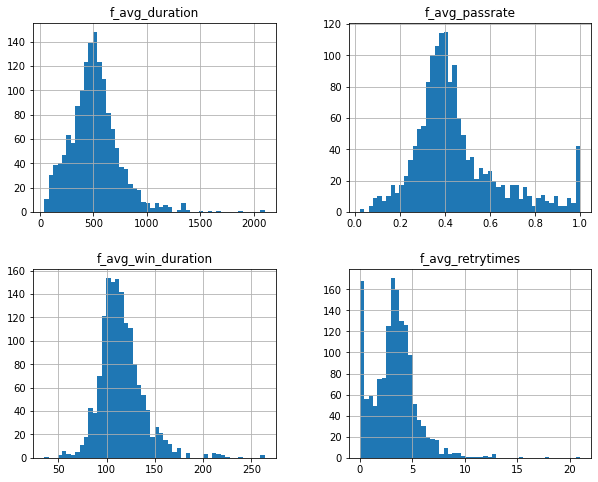

In [14]:
raw_level_meta_df[feats][~raw_level_meta_df.level_id.isin(['983', '1015'])].hist(figsize=(10, 8), bins=50)

level数据相关性

array([[<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_retrytimes', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='level_id', ylabel='f_avg_duration'>],
       [<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_retrytimes', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='level_id', ylabel='f_avg_passrate'>],
       [<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_retrytimes'

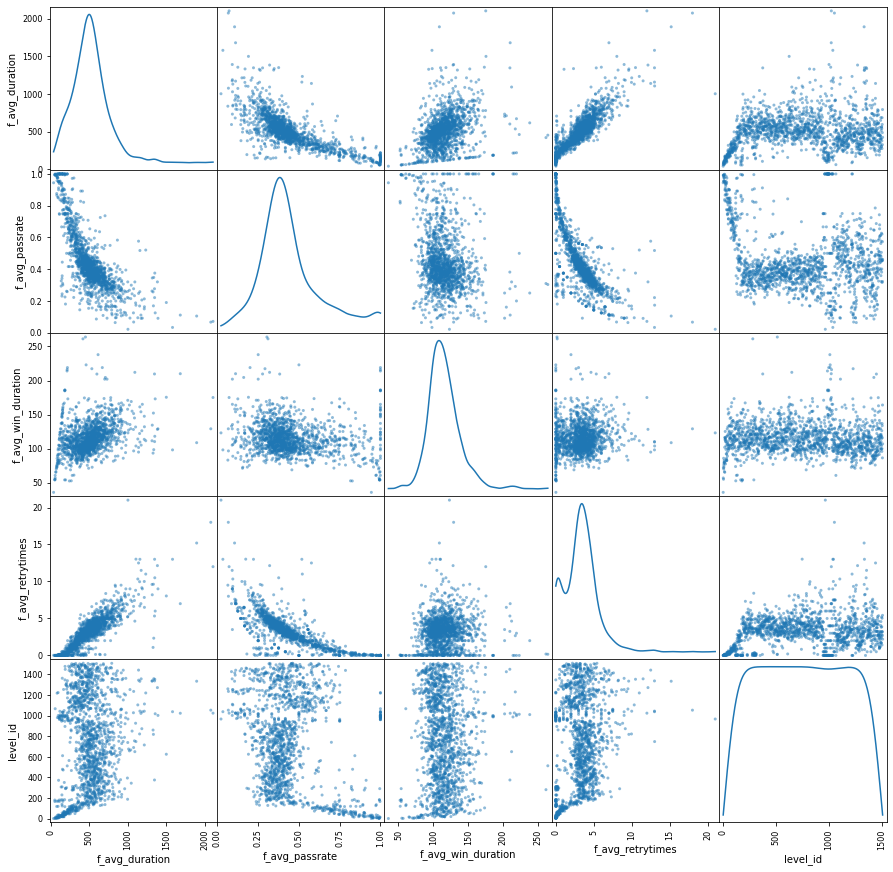

In [15]:
tmp_df = raw_level_meta_df[~raw_level_meta_df.level_id.isin(['983', '1015'])]
pd.plotting.scatter_matrix(tmp_df, figsize=(15, 15), diagonal='kde')

数据通关序列

In [16]:
raw_level_seq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194351 entries, 0 to 2194350
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     int64  
 1   level_id    int64  
 2   f_success   int64  
 3   f_duration  float64
 4   f_reststep  float64
 5   f_help      int64  
 6   time        object 
dtypes: float64(2), int64(4), object(1)
memory usage: 117.2+ MB


In [17]:
raw_level_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


时间特征

In [18]:
time_series = raw_level_seq_df['time']
min(time_series), max(time_series)

('2020-02-01 00:00:20', '2020-02-04 23:59:59')

In [19]:
raw_level_seq_df[raw_level_seq_df.user_id==10931]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
2194295,10931,1,1,28.0,0.500000,0,2020-02-02 00:01:33
2194296,10931,2,1,63.0,0.629630,0,2020-02-02 00:03:58
2194297,10931,3,1,61.0,0.400000,0,2020-02-02 00:05:39
2194298,10931,4,1,26.0,0.800000,0,2020-02-02 00:06:34
2194299,10931,5,0,129.0,0.000000,0,2020-02-02 00:09:14
2194300,10931,5,0,119.0,0.000000,0,2020-02-02 00:11:15
2194301,10931,5,1,87.0,0.583333,0,2020-02-02 00:12:44
2194302,10931,6,1,53.0,0.685714,0,2020-02-02 00:13:39
2194303,10931,7,1,98.0,0.500000,0,2020-02-02 00:16:12
2194304,10931,8,1,72.0,0.300000,0,2020-02-02 00:18:09


In [20]:
raw_train_df[raw_train_df.user_id==10931] 

,user_id,label
8157,10931,0


## 数据预处理和特征工程

合并训练、验证和测试集

In [21]:
raw_test_df['label'] = -1
df = pd.concat([raw_test_df, raw_train_df, raw_dev_df])
seq_df = copy.deepcopy(raw_level_seq_df)
meta_df = copy.deepcopy(raw_level_meta_df)

<AxesSubplot:>

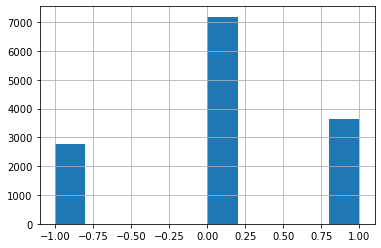

In [22]:
df['label'].hist()

In [23]:
df['label'].value_counts() / len(df.label)

 0    0.528736
 1    0.267201
-1    0.204062
Name: label, dtype: float64

In [24]:
seq_df['date_time'] =  pd.to_datetime(seq_df.time)
seq_df['tm_date'] = seq_df.date_time.dt.date
seq_df['tm_date_str'] = seq_df['tm_date'].astype('str')
seq_df['tm_day'] = seq_df.date_time.dt.day
seq_df['tm_hour'] = seq_df.date_time.dt.hour

In [25]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,date_time,tm_date,tm_date_str,tm_day,tm_hour
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020-02-01,1,0
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020-02-01,1,0
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020-02-01,1,0
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020-02-01,1,0
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020-02-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,2020-02-03 16:26:37,2020-02-03,2020-02-03,3,16
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,2020-02-03 16:28:06,2020-02-03,2020-02-03,3,16
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,2020-02-03 16:30:17,2020-02-03,2020-02-03,3,16
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,2020-02-03 16:33:40,2020-02-03,2020-02-03,3,16


In [26]:
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


从用户登录、等级、游戏水平等维度设计特征

* 用户登录次数
* 用户等级
* 用户游戏水平
* 用户通关情况

用户等级

In [27]:
tmp = seq_df.groupby('user_id')['level_id'].aggregate(['max'])
tmp = tmp.reset_index()
tmp.columns = ['user_id', 'level_max']

df = df.merge(tmp, on='user_id', how='left')

用户通关比例
> 过拟合特征

In [28]:
# total_level = max(meta_df['level_id'])

# df['level_ratio'] = df['level_max'] / total_level

用户每天是否登录，登录天数

In [29]:
tmp = seq_df.drop_duplicates(['user_id', 'tm_date'], keep='first')
tmp = tmp.pivot(index='user_id', columns='tm_date_str')['level_id']
tmp = tmp.fillna(0)
tmp = tmp.astype('bool').astype('int').reset_index()
tmp.columns = ['user_id'] + ['login_0201', 'login_0202', 'login_0203', 'login_0204']

df = df.merge(tmp, on='user_id', how='left')

In [30]:
df['login_days'] = df[['login_0201', 'login_0202', 'login_0203', 'login_0204']].sum(axis=1)

In [31]:
login_feats = ['login_0201', 'login_0202', 'login_0203', 'login_0204']

用户成功、失败尝试次数

In [32]:
success_tmp = seq_df[seq_df.f_success==1].groupby(['user_id'])['f_success'].agg(success_sum='sum').reset_index()
fail_tmp = seq_df[seq_df.f_success==0].groupby(['user_id'])['f_success'].agg(fail_sum='count').reset_index()
fail_tmp = fail_tmp.fillna(0)

df = df.merge(success_tmp, on='user_id', how='left')
df = df.merge(fail_tmp, on='user_id', how='left')

用户花费时间统计

In [33]:
tmp = seq_df.groupby('user_id')['f_duration'].agg(total_duration='sum').reset_index()
df = df.merge(tmp, on='user_id', how='left')

用户每天花费时间统计

In [34]:
day_duration = ['day_duration_0201', 'day_duration_0202', 'day_duration_0203', 'day_duration_0204']

In [35]:
tmp = seq_df[['user_id', 'tm_date_str', 'f_duration']]
tmp = tmp.groupby(['user_id', 'tm_date_str'])['f_duration'].agg(day_duration='sum').reset_index()
tmp = tmp.pivot(index='user_id', columns='tm_date_str')
tmp = tmp.fillna(0).reset_index()
tmp.columns = ['user_id'] + day_duration

df = df.merge(tmp, on='user_id', how='left')

用户玩游戏时间分布

<AxesSubplot:>

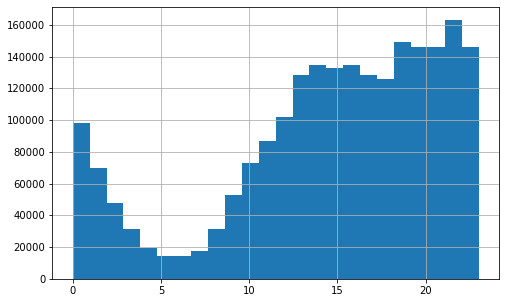

In [36]:
seq_df.tm_hour.hist(bins=24, figsize=(8, 5))

用户使用帮助统计

In [37]:
tmp = seq_df.groupby('user_id')['f_help'].agg(help_sum='sum').reset_index()
df = df.merge(tmp, on='user_id', how='left')

## 准备数据集

In [38]:
df = df.fillna(0)

In [39]:
df.tail(10).T

,13579,13580,13581,13582,13583,13584,13585,13586,13587,13588
user_id,13580.0,13581.0,13582.0,13583.0,13584.0,13585.0,13586.0,13587.0,13588.0,13589.0
label,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
level_max,59.0,3.0,231.0,117.0,39.0,135.0,179.0,111.0,27.0,19.0
login_0201,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
login_0202,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
login_0203,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
login_0204,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
login_days,3.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,2.0
success_sum,59.0,3.0,193.0,88.0,38.0,112.0,139.0,14.0,27.0,17.0
fail_sum,11.0,0.0,14.0,25.0,3.0,136.0,172.0,6.0,1.0,4.0


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
final_feats = ['level_max', 'success_sum', 'fail_sum', 'total_duration', 'help_sum'] + login_feats + day_duration

In [42]:
train_df = df[df.label != -1]
test_df = df[df.label == -1]

X, y = train_df[final_feats], train_df['label']
ret = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = ret

In [43]:
X_test = test_df[final_feats]

In [44]:
print('Train dataset X: %s, y: %s' % (X_train.shape, y_train.shape))
print('Val   dataset X: %s, y: %s' % (X_val.shape, y_val.shape))
print('Test  dataset X: %s' % str(X_test.shape))

Train dataset X: (8652, 13), y: (8652,)
Val   dataset X: (2164, 13), y: (2164,)
Test  dataset X: (2773, 13)


## 模型

### LightGBM

In [45]:
from lightgbm.sklearn import LGBMModel

训练

In [46]:
lgb_params = {
    'num_leaves': 15,
    'max_depth': 20,
    'n_estimators': 1000,
    'min_split_gain': 1e-4,
    'min_child_samples': 20,
    'random_state': 42,
    'objective': 'binary',
    'metric': ['auc']
}

In [47]:
lgb_model = LGBMModel(**lgb_params)

In [48]:
lgb_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, eval_metric='auc')

[1]	valid_0's auc: 0.799183
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.80199
[3]	valid_0's auc: 0.802676
[4]	valid_0's auc: 0.803677
[5]	valid_0's auc: 0.803902
[6]	valid_0's auc: 0.803549
[7]	valid_0's auc: 0.804161
[8]	valid_0's auc: 0.804219
[9]	valid_0's auc: 0.805475
[10]	valid_0's auc: 0.804844
[11]	valid_0's auc: 0.805883
[12]	valid_0's auc: 0.806086
[13]	valid_0's auc: 0.806665
[14]	valid_0's auc: 0.807212
[15]	valid_0's auc: 0.807641
[16]	valid_0's auc: 0.807701
[17]	valid_0's auc: 0.807679
[18]	valid_0's auc: 0.80762
[19]	valid_0's auc: 0.807744
[20]	valid_0's auc: 0.808356
[21]	valid_0's auc: 0.808094
[22]	valid_0's auc: 0.808123
[23]	valid_0's auc: 0.808399
[24]	valid_0's auc: 0.808253
[25]	valid_0's auc: 0.807968
[26]	valid_0's auc: 0.807894
[27]	valid_0's auc: 0.807983
[28]	valid_0's auc: 0.807645
[29]	valid_0's auc: 0.807309
[30]	valid_0's auc: 0.807092
[31]	valid_0's auc: 0.807249
[32]	valid_0's auc: 0.807626
[33]	valid_0's auc: 0.

LGBMModel(max_depth=20, metric=['auc'], min_split_gain=0.0001,
          n_estimators=1000, num_leaves=15, objective='binary',
          random_state=42)

评估

In [49]:
roc_auc_score(y_train, lgb_model.predict(X_train))

0.873762509811617

In [50]:
roc_auc_score(y_val, lgb_model.predict(X_val))

0.8093141666385936

预测

In [51]:
y_pred = lgb_model.predict(X_test)

特征重要性

In [52]:
lgb_model.feature_importances_

array([177, 173, 135, 195, 125,   0,   0,   2,  14, 203, 189, 182, 173],
      dtype=int32)

In [53]:
lgb_model.feature_name_

['level_max',
 'success_sum',
 'fail_sum',
 'total_duration',
 'help_sum',
 'login_0201',
 'login_0202',
 'login_0203',
 'login_0204',
 'day_duration_0201',
 'day_duration_0202',
 'day_duration_0203',
 'day_duration_0204']

In [54]:
feat_importance = pd.DataFrame({
    'feat': lgb_model.feature_name_,
    'importance': lgb_model.feature_importances_
})

feat_importance = feat_importance.sort_values('importance', ascending=True).reset_index(drop=True)

<AxesSubplot:title={'center':'LightGBM'}, ylabel='feat'>

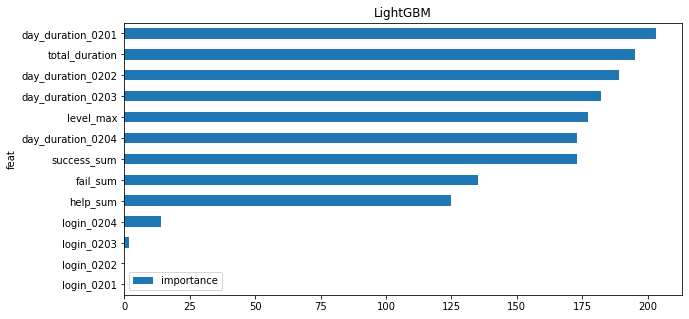

In [55]:
feat_importance.plot.barh(x='feat', y='importance', figsize=(10, 5), title='LightGBM')

### Catboost

训练

In [56]:
cat_params = {
    'iterations': 1000,
    'depth': 5,
    'learning_rate': 1e-3,
    'loss_function': 'Logloss',
    'verbose': True,
    'early_stopping_rounds': 100,
    'eval_metric': 'AUC'
}
cat_model = catboost.CatBoostClassifier(**cat_params)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7903533	best: 0.7903533 (0)	total: 58.2ms	remaining: 58.1s
1:	test: 0.7986689	best: 0.7986689 (1)	total: 64.9ms	remaining: 32.4s
2:	test: 0.8003879	best: 0.8003879 (2)	total: 73.5ms	remaining: 24.4s
3:	test: 0.8034323	best: 0.8034323 (3)	total: 80.5ms	remaining: 20s
4:	test: 0.8056148	best: 0.8056148 (4)	total: 87.2ms	remaining: 17.4s
5:	test: 0.8069426	best: 0.8069426 (5)	total: 92.6ms	remaining: 15.3s
6:	test: 0.8067991	best: 0.8069426 (5)	total: 98.8ms	remaining: 14s
7:	test: 0.8069411	best: 0.8069426 (5)	total: 104ms	remaining: 13s
8:	test: 0.8071529	best: 0.8071529 (8)	total: 109ms	remaining: 12s
9:	test: 0.8073588	best: 0.8073588 (9)	total: 114ms	remaining: 11.3s
10:	test: 0.8065912	best: 0.8073588 (9)	total: 120ms	remaining: 10.8s
11:	test: 0.8072385	best: 0.8073588 (9)	total: 126ms	remaining: 10.3s
12:	test: 0.8070595	best: 0.8073588 (9)	total: 132ms	remaining: 9.99s
13:	test: 0.8074719	best: 0.8074719 (13)	total: 137ms	remaining: 9.65s
14:	test: 0.8074055	best: 0.80

评估

In [57]:
print('Train dataset auc: %.6f' % roc_auc_score(y_train, cat_model.predict_proba(X_train)[:,1]))
print('Val   dataset auc: %.6f' % roc_auc_score(y_val, cat_model.predict_proba(X_val)[:,1]))

Train dataset auc: 0.802708
Val   dataset auc: 0.808133


预测

In [58]:
y_pred = cat_model.predict_proba(X_test)[:,1]

> Final Submission

特征重要性

In [59]:
feat_importance = pd.DataFrame({
    'feat': cat_model.feature_names_,
    'importance': cat_model.feature_importances_
})

feat_importance = feat_importance.sort_values('importance', ascending=True).reset_index(drop=True)

In [60]:
feat_importance

,feat,importance
0,login_0201,0.000000
1,login_0202,0.159515
2,help_sum,0.275319
3,day_duration_0201,0.416598
4,day_duration_0202,1.152500
5,level_max,1.805604
6,total_duration,3.158533
7,fail_sum,3.664328
8,success_sum,3.793056
9,day_duration_0203,8.543359


<AxesSubplot:title={'center':'CatBoost'}, ylabel='feat'>

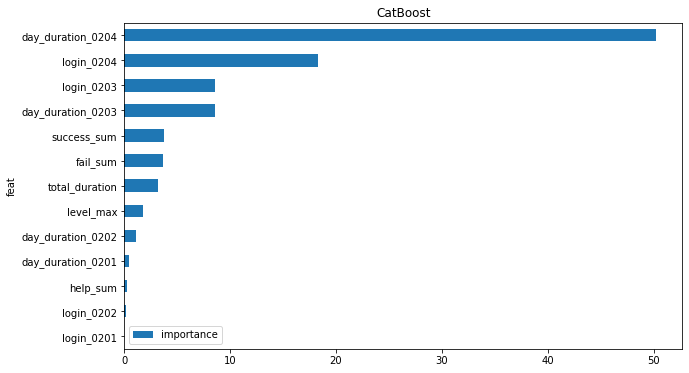

In [61]:
feat_importance.plot.barh(x='feat', y='importance', figsize=(10, 6), title='CatBoost')

### Catboost + LightGBM Ensemble

In [62]:
roc_auc_score(y_val, (lgb_model.predict(X_val) + cat_model.predict_proba(X_val)[:,1])/2)

0.8096640374222176

In [63]:
y_pred = (lgb_model.predict(X_test) + cat_model.predict_proba(X_test)[:,1])/2

> 使用catboost单模最优

### 使用全部数据进行训练

In [64]:
# from sklearn.model_selection import KFold

In [65]:
# n_splits = 5

# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# y_pred = np.zeros((len(X_test), 2))

# for train_index, val_index in kfold.split(X, y):
#     X_train, y_train = X.iloc[train_index,:], y.iloc[train_index]
#     X_val, y_val = X.iloc[val_index,:], y.iloc[val_index]
    
#     model = catboost.CatBoostClassifier(**params)
#     model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
#     y_pred += model.predict_proba(X_test)

# y_pred /= n_splits

> 分数无变化

## 提交数据

In [66]:
result = pd.DataFrame({
    'user_id': df[df.label == -1]['user_id'],
    'proba': y_pred,
})

result.to_csv('submission/result.csv', index=False)